Steps

- Run an experiment where we filter out Sentinel-2 items with >85% no data pixels. This is saved in `s3://drivendata-competition-nasa-cyanobacteria/experiments/results/filter_nodata`
- Compare our no data filter experiment to the current best model. Best model evaluation metrics are saved in `s3://drivendata-competition-nasa-cyanobacteria/predictions/competition_near_water_550m`

### Takeaway (spoiler!)

Overall, I'm pretty on the fence but I lean towards implementing this.

- The only samples that are dropped from prediction and training are older samples, so this change is unlikely to affect the number of samples we are able to predict on in the future
- The largest difference in performance is better identification of high-severity samples. There is some loss of performance in identifying low-severity samples, but the change is smaller.

In [1]:
%load_ext lab_black

In [2]:
import json

from cloudpathlib import AnyPath
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cyano.data.utils import add_unique_identifier, convert_density_to_severity
from cyano.evaluate import EvaluatePreds, generate_and_plot_severity_crosstab

In [3]:
s3_dir = AnyPath("s3://drivendata-competition-nasa-cyanobacteria")

## Load data

In [4]:
true = pd.read_csv(s3_dir / "experiments/splits/competition_near_water_550m/test.csv")
true = add_unique_identifier(true)

# update severity bins
true["severity"] = convert_density_to_severity(true.density_cells_per_ml)

In [5]:
best_model_dir = s3_dir / "predictions/competition_near_water_550m"
experiment_dir = s3_dir / "experiments/results/filter_nodata"

baseline_preds = pd.read_csv(best_model_dir / "preds.csv", index_col=0)
new_preds = pd.read_csv(experiment_dir / "preds.csv", index_col=0)
assert new_preds.index.isin(baseline_preds.index).all()

In [6]:
# How many samples do we have predictions on for each?
# We only drop ~30 samples
print(
    f"{baseline_preds.density_cells_per_ml.notna().sum():,} samples included for best model"
)
print(
    f"{new_preds.density_cells_per_ml.notna().sum():,} samples included with nodata filter"
)

3,721 samples included for best model
3,690 samples included with nodata filter


Load the test set satellite metadata to make sure the number of samples dropped looks right

In [7]:
sat_meta = pd.read_csv(
    s3_dir
    / "experiments/cache/24de5d25cd622ba21a012cf10fd4e57b/satellite_metadata_test.csv"
)

print(f"{sat_meta.sample_id.nunique():,} samples total in satellite metadata")

# how many samples have imagery with < 85% no data?
ct_with_valid_imagery = sat_meta[
    sat_meta["s2:nodata_pixel_percentage"] < 85
].sample_id.nunique()
print(f"{ct_with_valid_imagery:,} samples have imagery with <85% nodata pixels")

3,745 samples total in satellite metadata
3,715 samples have imagery with <85% nodata pixels


Yup, the sample count checks -- we should lose ~30 samples.

## Compare performance

Baseline (current best model) left.     New model with nodata pixel filter right

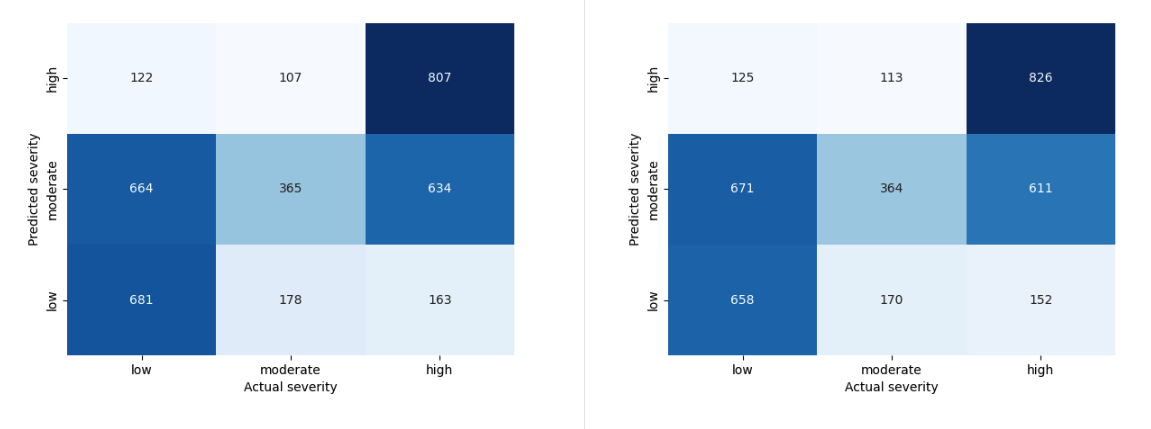

In [8]:
with (best_model_dir / "metrics/results.json").open("r") as fp:
    baseline_res = json.load(fp)

with (experiment_dir / "metrics/results.json").open("r") as fp:
    experiment_res = json.load(fp)

In [9]:
# see overall severity stats
pd.DataFrame(
    {
        "baseline": baseline_res["severity"],
        "nodata_filer": experiment_res["severity"],
    }
).drop(index=["regional_rmse", "regional_mae", "classification_report"]).T

,overall_rmse,overall_mae,region_averaged_rmse
baseline,0.855449,0.578608,0.844798
nodata_filer,0.851111,0.574255,0.834577


In [10]:
# see log density stats
pd.DataFrame(
    {
        "baseline": baseline_res["log_density"],
        "nodata_filer": experiment_res["log_density"],
    }
).drop(index=["regional_r_squared"]).T

,overall_r_squared,overall_mape
baseline,0.295335,986034919492603.125
nodata_filer,0.301836,989935940270515.125


In [11]:
# see regional severity rmse
regional_rmses = pd.DataFrame(
    {
        "baseline": baseline_res["severity"]["regional_rmse"],
        "nodata_filter": experiment_res["severity"]["regional_rmse"],
    }
)
regional_rmses["change"] = regional_rmses["nodata_filter"] - regional_rmses["baseline"]
regional_rmses.T

,midwest,northeast,south,west
baseline,0.819063,0.875329,1.030409,0.654393
nodata_filter,0.829824,0.863234,1.035745,0.609506
change,0.010760,-0.012094,0.005336,-0.044886


In [12]:
# see regional r squared
regional_rsquared = pd.DataFrame(
    {
        "baseline": baseline_res["log_density"]["regional_r_squared"],
        "nodata_filter": experiment_res["log_density"]["regional_r_squared"],
    }
)
regional_rsquared["change"] = (
    regional_rsquared["nodata_filter"] - regional_rsquared["baseline"]
)
regional_rsquared.T

,midwest,northeast,south,west
baseline,0.291573,-0.019478,-0.232726,-0.800798
nodata_filter,0.292807,-0.017861,-0.239606,-0.662821
change,0.001235,0.001617,-0.006880,0.137976


Largest regional difference is improvement in the west. Performance in the south is worse, but not by as much.

#### Samples dropped from predictions

<Axes: xlabel='Actual severity', ylabel='Predicted severity'>

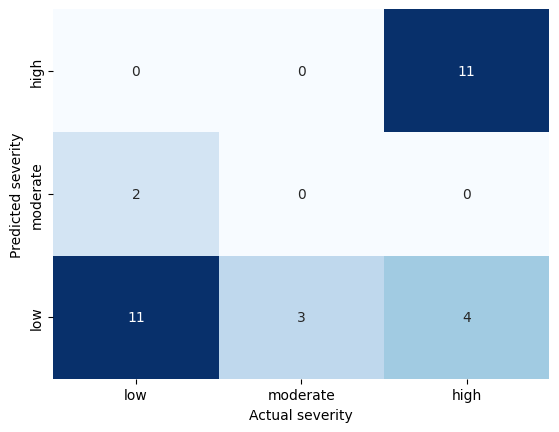

In [13]:
# How does our best model perform on samples that are dropped from prediction by the new model?
dropped_samples = new_preds[new_preds.severity.isna()].index

generate_and_plot_severity_crosstab(
    y_true=true.loc[dropped_samples].severity,
    y_pred=baseline_preds.loc[dropped_samples].severity,
)

The model still performs okay on these samples, although not as well as it does on the overall data.

In [14]:
# WHERE are these dropped samples from?
# spread pretty evenly across regions
true.loc[dropped_samples].region.value_counts()

region
west         373
midwest      368
south        254
northeast    253
Name: count, dtype: int64

In [15]:
# WHEN are these dropped samples from?
# Almost entirely 2017 and earlier
pd.to_datetime(true.loc[dropped_samples].date).dt.year.value_counts().sort_index()

date
2013    347
2014    398
2015    367
2016     62
2017     65
2021      9
Name: count, dtype: int64

**Takeaway**

The baseline model does fairly well on samples that are dropped when we filter out images with >85% no data pixels. These samples only have feature information from land cover and from images with mostly no data pixels.
- This implies that no data pixels can still be useful for prediction. Some pixels could be mislabeled as no data, or some images could have actual data pixels right around our sample point even if most pixels are no data.

Almost all samples that are dropped from prediction are from early years of sentinel. If we implemented this nodata pixel filter, it likely wouldn't impact the number of samples we are able to predict on in the future.

#### Change in predictions

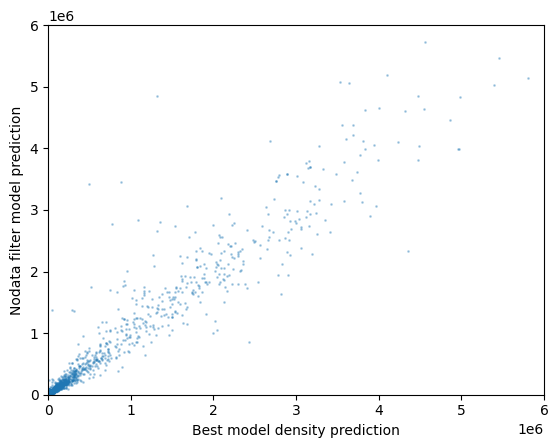

In [16]:
# For most samples, there is not much change in prediction
plt.plot(
    baseline_preds.loc[new_preds.index].density_cells_per_ml,
    new_preds.density_cells_per_ml,
    ".",
    markersize=2,
    alpha=0.3,
)

plt.xlim([0, 6e6])
plt.ylim([0, 6e6])

plt.xlabel("Best model density prediction")
plt.ylabel("Nodata filter model prediction")

plt.show()

The severity prediction changed for 346 samples


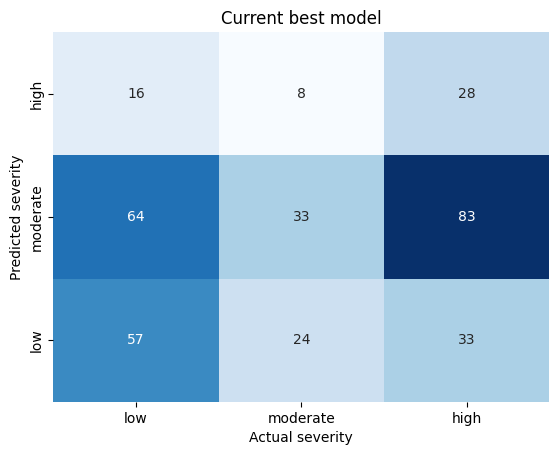

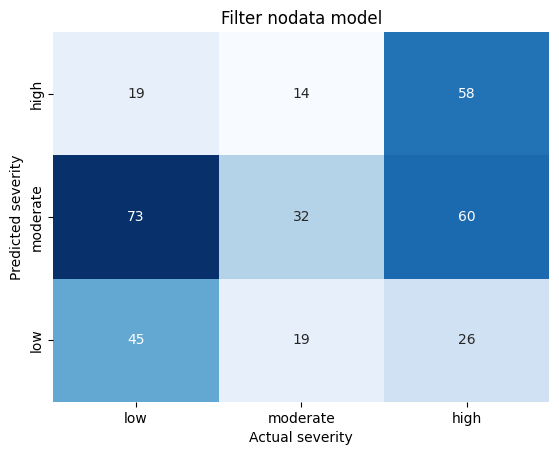

In [17]:
# see just the samples that change severity prediction
mask = (new_preds.severity != baseline_preds.loc[new_preds.index].severity) & (
    new_preds.density_cells_per_ml.notna()
)
sample_ids = new_preds[mask].index
print(f"The severity prediction changed for {len(sample_ids):,} samples")

generate_and_plot_severity_crosstab(
    y_true=true.loc[sample_ids].severity, y_pred=baseline_preds.loc[sample_ids].severity
)
plt.title("Current best model")

generate_and_plot_severity_crosstab(
    y_true=true.loc[sample_ids].severity, y_pred=new_preds.loc[sample_ids].severity
)
plt.title("Filter nodata model")
plt.show()

In [18]:
# where are the samples whose severity prediction changes?
true.loc[sample_ids].region.value_counts()

region
south        132
midwest       97
northeast     63
west          54
Name: count, dtype: int64

The severity level predictions changes for ~350 samples. The new model performs worse on low-severity samples, but better by a slightly larger margin on high-severity samples. Performance on mid-severity samples is the same.

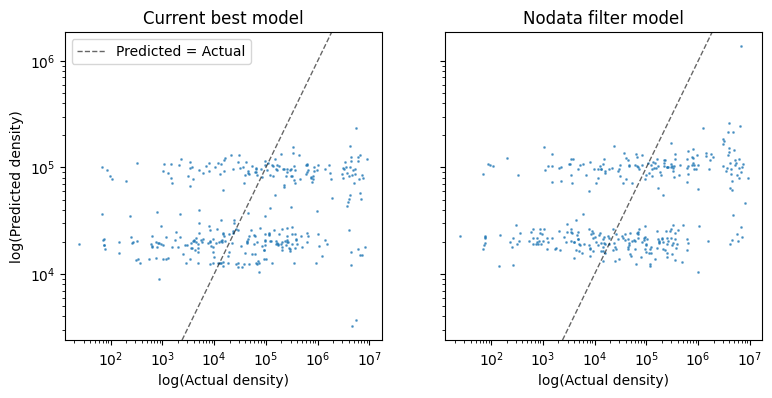

In [19]:
_, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)


for preds, ax in zip([baseline_preds, new_preds], axes):
    ax.plot(
        true.loc[sample_ids].density_cells_per_ml,
        preds.loc[sample_ids].density_cells_per_ml,
        ".",
        markersize=2,
        alpha=0.6,
    )
    ax.axline(
        (0, 0),
        (1e6, 1e6),
        color="black",
        linestyle="--",
        alpha=0.6,
        linewidth=1,
        label="Predicted = Actual",
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("log(Actual density)")

axes[0].set_ylabel("log(Predicted density)")
axes[0].set_title("Current best model")
axes[1].set_title("Nodata filter model")
axes[0].legend()
plt.show()

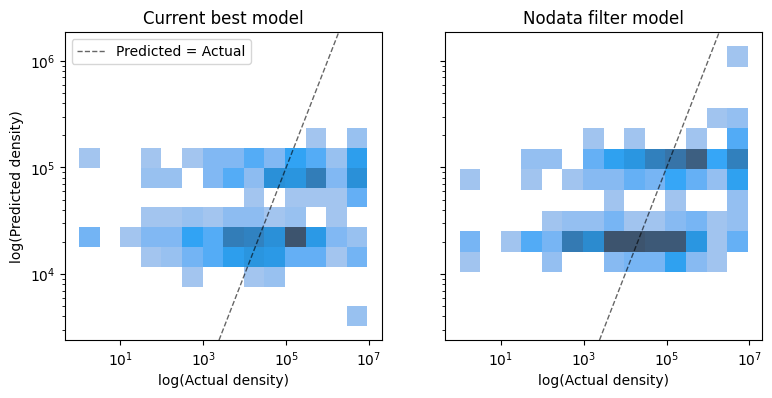

In [20]:
_, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)


for preds, ax in zip([baseline_preds, new_preds], axes):
    sns.histplot(
        x=true.loc[sample_ids].density_cells_per_ml + 1,
        y=preds.loc[sample_ids].density_cells_per_ml + 1,
        ax=ax,
        log_scale=True,
    )
    ax.axline(
        (0, 0),
        (1e6, 1e6),
        color="black",
        linestyle="--",
        alpha=0.6,
        linewidth=1,
        label="Predicted = Actual",
    )
    ax.set_xlabel("log(Actual density)")

axes[0].set_ylabel("log(Predicted density)")
axes[0].set_title("Current best model")
axes[1].set_title("Nodata filter model")
axes[0].legend()
plt.show()